In [13]:
import os
import sys
import glob
import pickle
import numpy as np
import pandas as pd
import catboost
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations

In [23]:
df_CC = pd.read_csv(
    "../../Campy_Github_tryout/data/C.jejuni-UKisolates-CC.csv").set_index('id')

df_NG = pd.read_csv(
    "../../Campy_Github_tryout/data/C.jejuni-UKisolates.csv").set_index('id')

df = pd.merge(df_CC, df_NG, left_index=True, right_index=True)
df = df.loc[df['cc'].notna()].fillna('Unknown')

df = df.astype(str)

In [24]:
mlst = pd.read_csv("../../Data/MLST_assighnment.tsv", sep='\t').set_index('ST')
mlst['cc_number'] = (
    mlst['clonal_complex']
    .fillna('ST-0 complex')
    .apply(lambda x: int(str(x).split(' ')[0].split('-')[1]))
)
mlst = mlst.loc[mlst['cc_number'] == mlst.index]
mlst = mlst.set_index('clonal_complex').drop(['cc_number'], axis=1).T

cols = [col.split(' ')[0] for col in mlst.columns]
mlst.columns = cols

mlst = mlst.astype(str)

<ipython-input-64-a3d705dfa415>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(4, 2, figsize=(8,9))


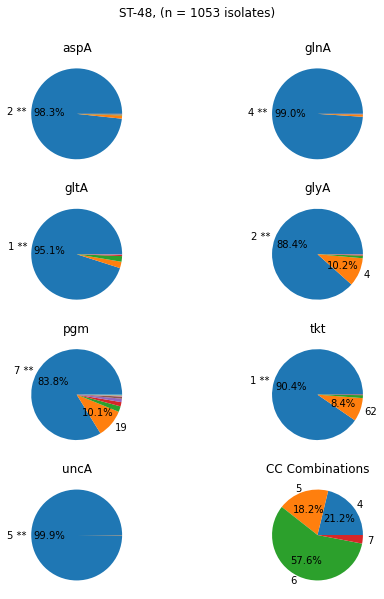

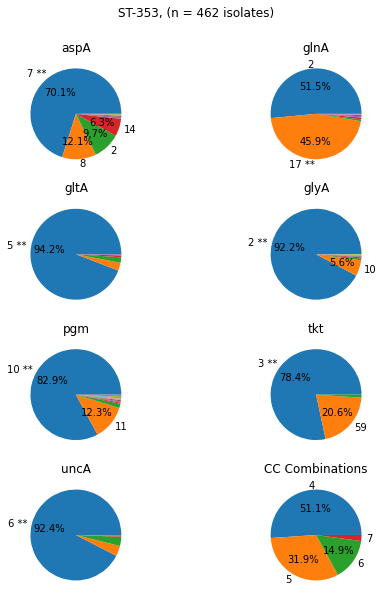

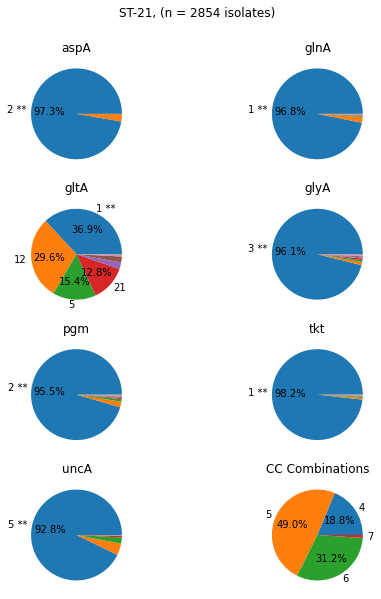

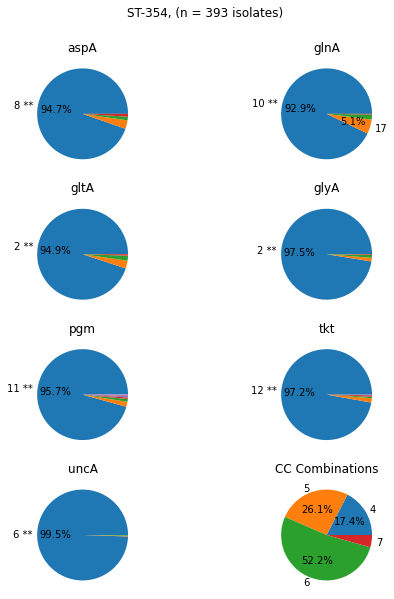

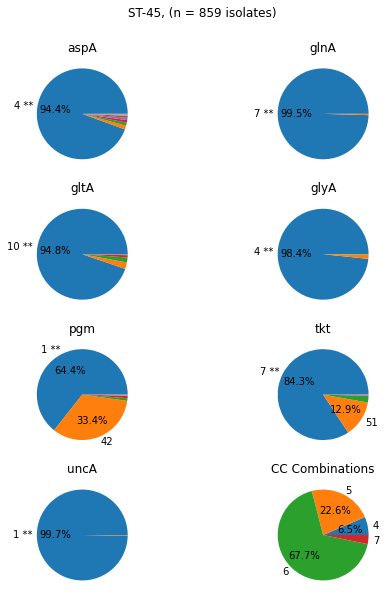

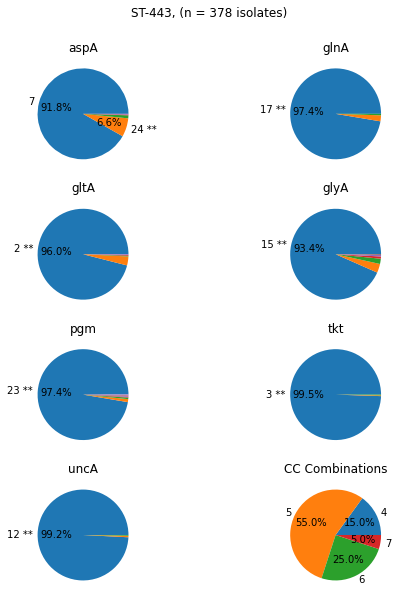

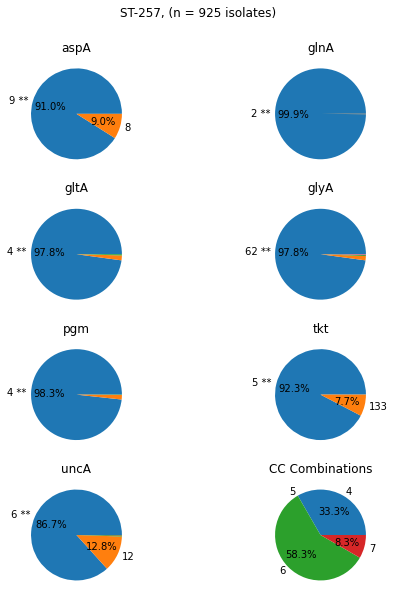

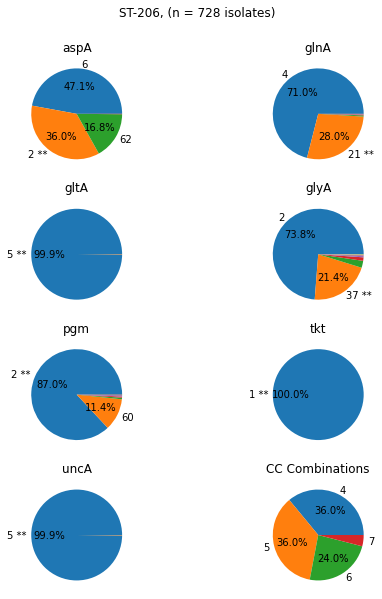

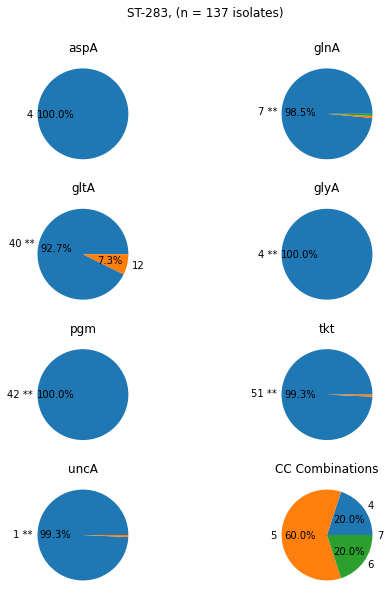

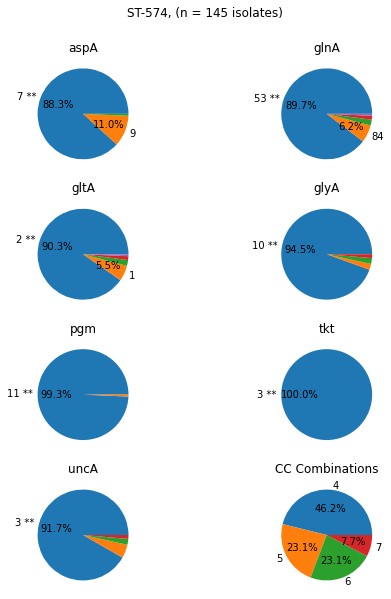

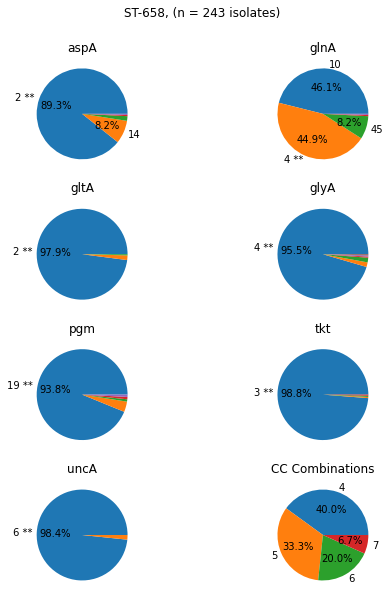

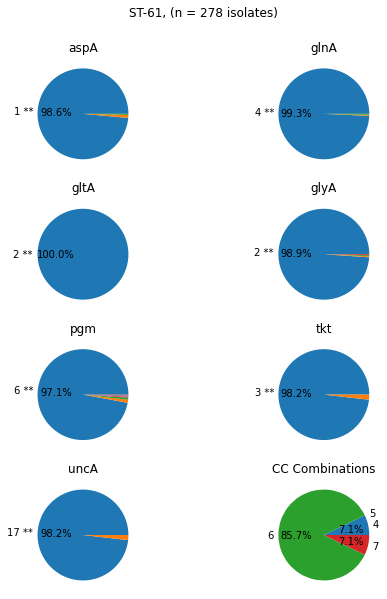

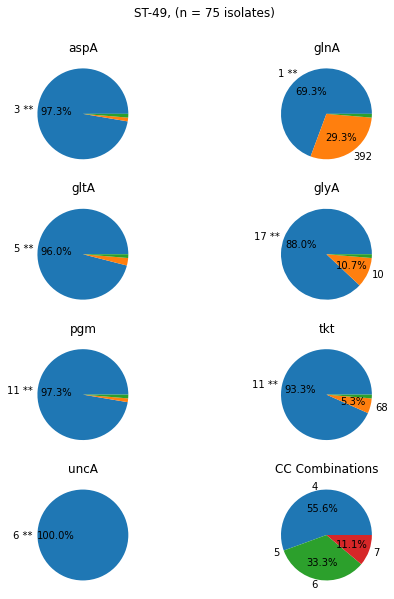

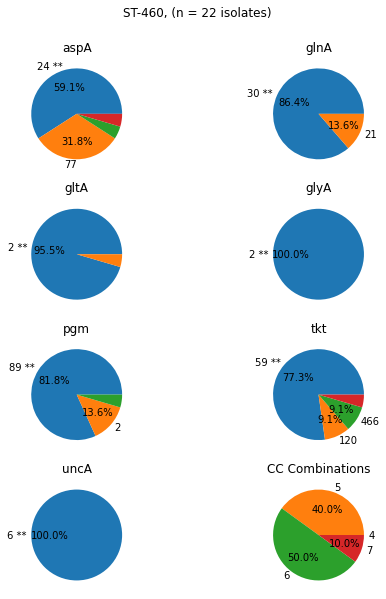

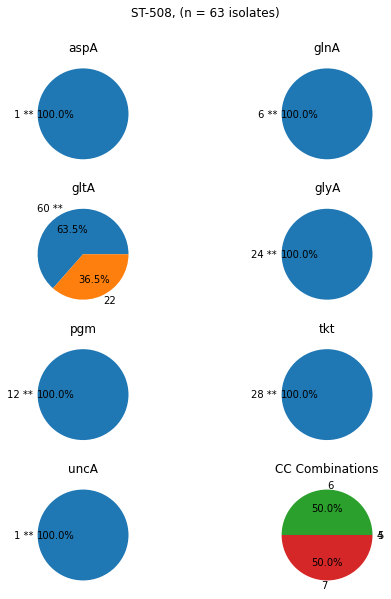

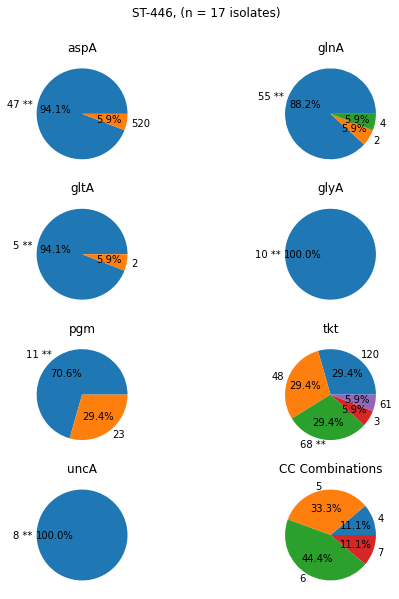

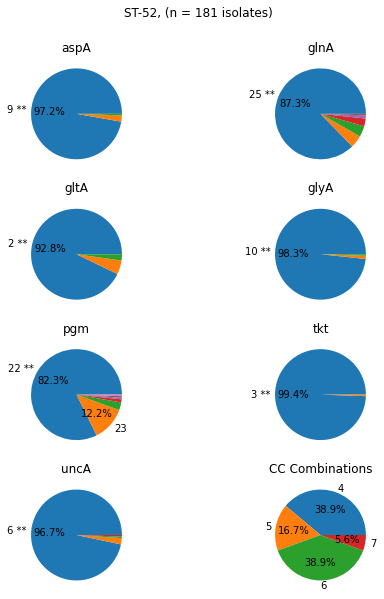

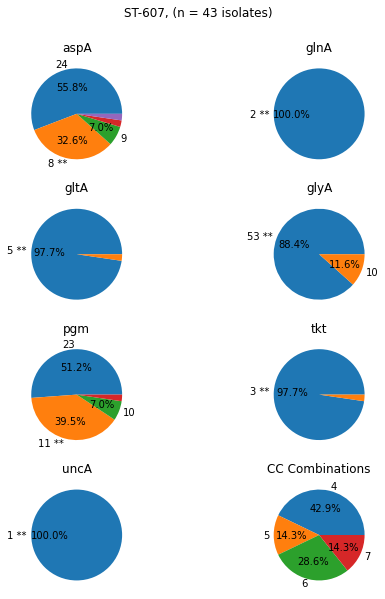

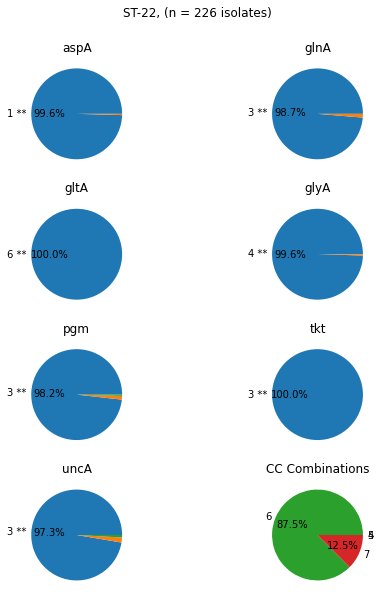

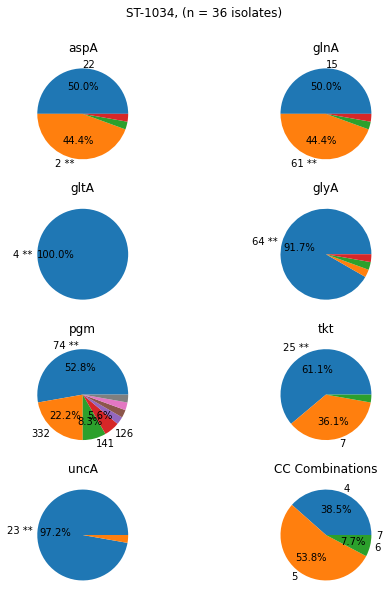

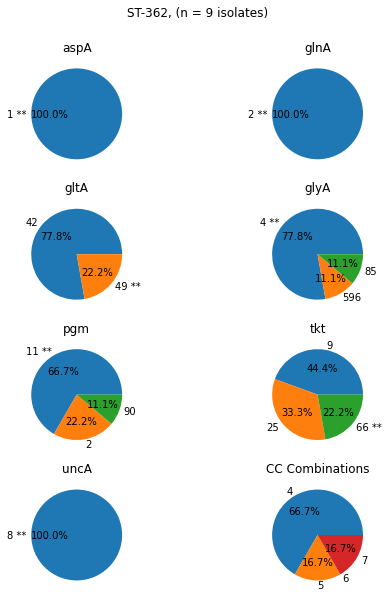

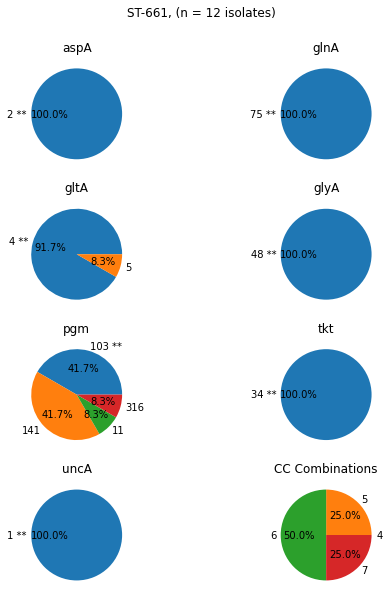

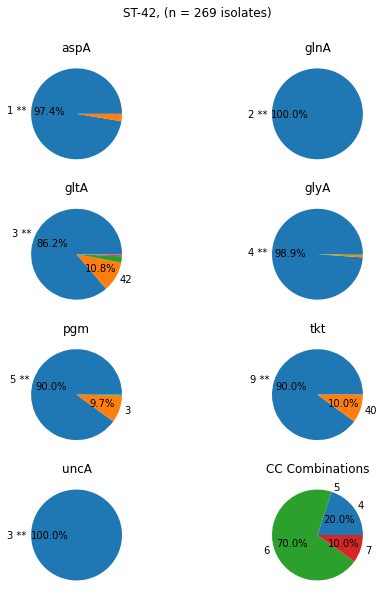

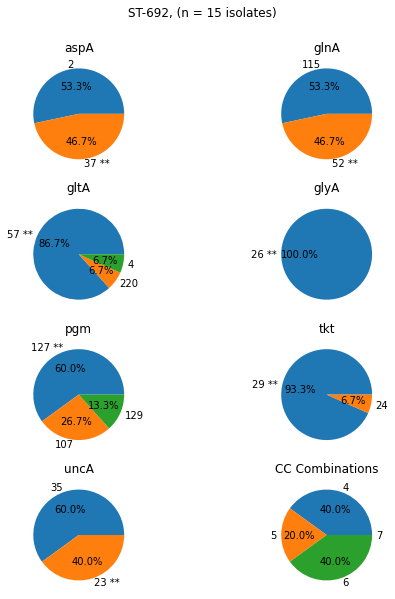

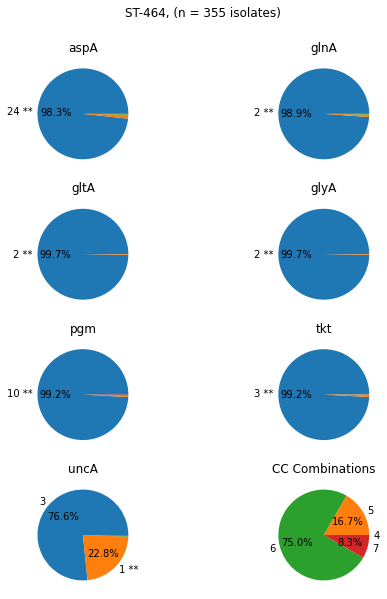

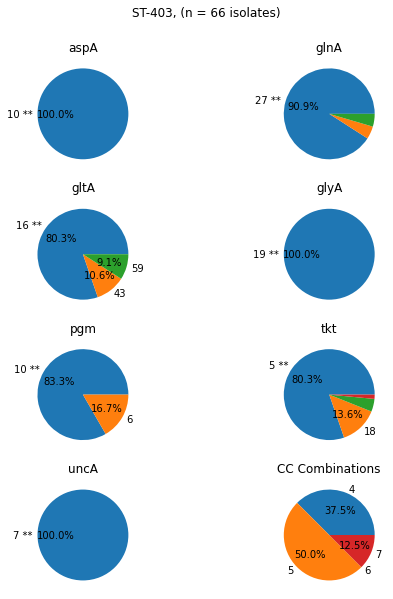

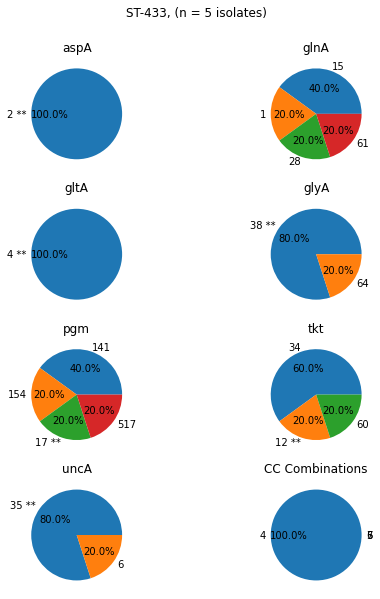

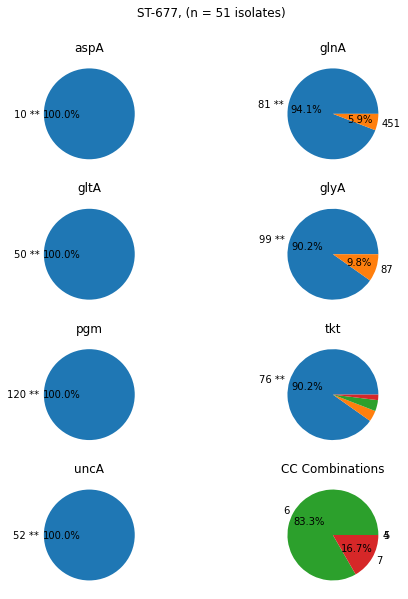

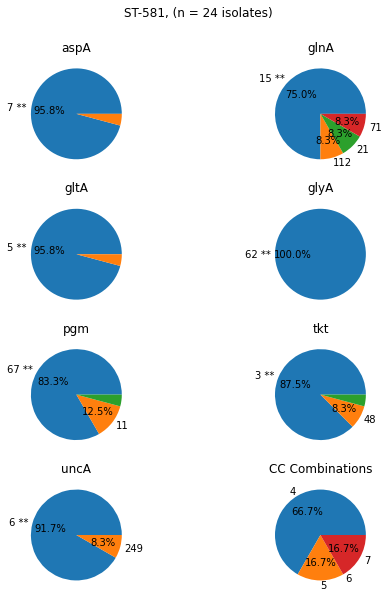

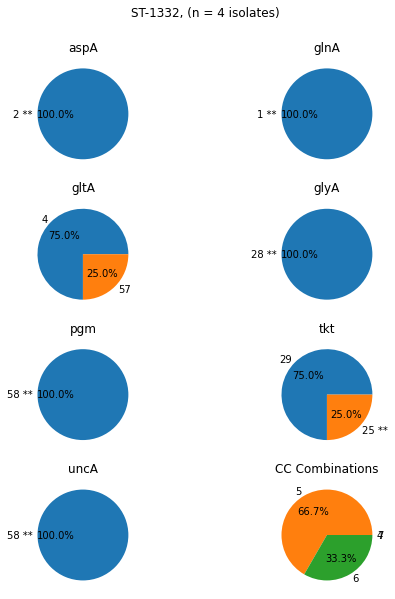

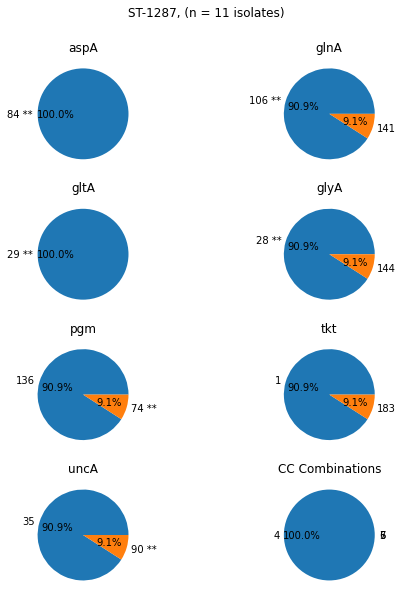

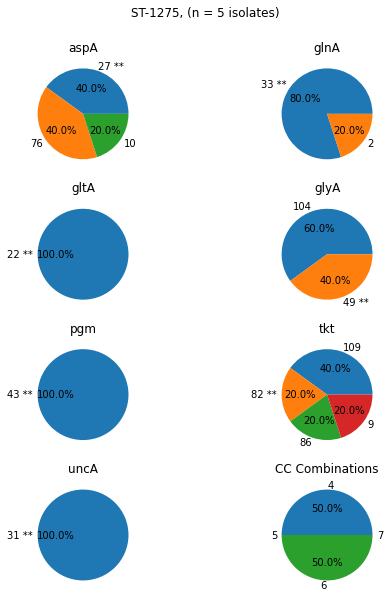

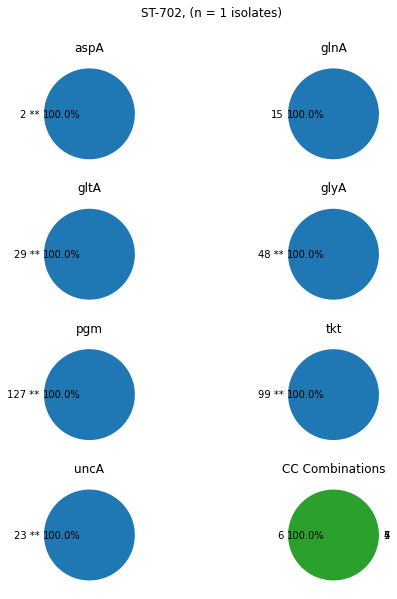

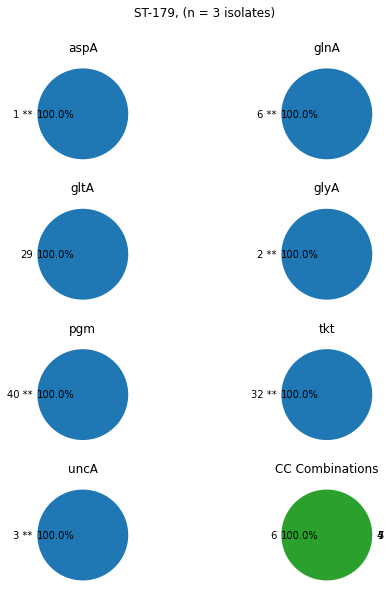

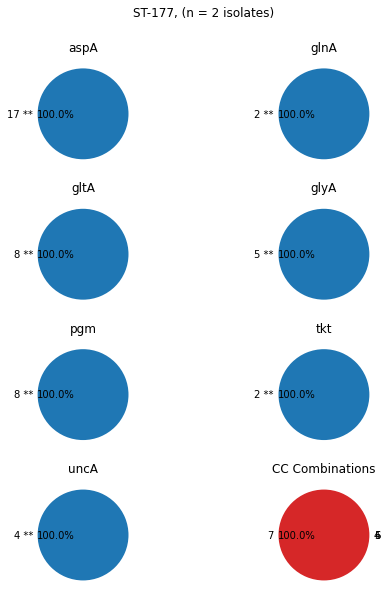

In [64]:
def custom_pct(pct):
    """ Exclude labels less than 5 percent """
    return ('%1.1f%%' % pct) if pct > 5 else ''

all_cc = []
for cc in df["cc"].unique():
    top_locus = {}
    df_combined = df[df["cc"] == cc] 

    fig, axes = plt.subplots(4, 2, figsize=(8,9))
    axes = axes.flatten()
    all_loci = ['aspA', 'glnA', 'gltA', 'glyA', 'pgm', 'tkt', 'uncA']

    for i, loci in enumerate(all_loci):
        counts = df_combined.groupby(loci).size().sort_values(ascending=False)
        
        ref = mlst.loc[mlst.index==loci, cc][0]
        labels = list(counts.index)
        labels = [f'{x} **' if x == ref else x for x in labels]
        
        # Set labels to blank if less than 5%
        pcts = (counts / counts.sum()) > 0.05
        new_labels = []
        for label, threshold in zip(labels, pcts):
            if threshold:
                new_labels.append(label)
            else:
                new_labels.append('')
        
        axes[i].pie(counts, labels=new_labels, autopct=custom_pct)
        axes[i].set_title(loci)
        
        most_freq = counts.sort_values().tail(1).index[0]
        top_locus[loci] = most_freq
        
    count_pie = (
        ((df_combined.drop('cc', axis=1).drop_duplicates()) == mlst[cc])
        .sum(axis=1)
        .value_counts()
        .reindex([4, 5, 6, 7])
        .fillna(0)
    )
    labels = count_pie.index
    axes[-1].pie(count_pie, labels=labels, autopct=custom_pct)
    axes[-1].set_title('CC Combinations')
    
    plt.suptitle(f'{cc}, (n = {counts.sum()} isolates)', y=0.95)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f'../../Figures/piechart/{cc}-locus-freq.png', dpi=300)

    all_cc.append(pd.Series(top_locus).rename(cc))

4    0.0
5    0.0
6    0.0
7    1.0
dtype: float64

In [47]:
(df_combined.drop('cc', axis=1))

,aspA,glnA,gltA,glyA,pgm,tkt,uncA
id,,,,,,,
2659,2,4,1,4,19,1,5
5891,2,4,1,2,5,1,5
5956,2,4,1,2,7,1,5
6082,2,4,1,4,19,62,5
6270,2,4,5,2,7,1,5
6389,2,4,1,2,7,51,5
14392,2,4,2,2,6,1,5
14765,7,4,5,2,11,1,5
14784,2,4,1,4,7,1,5


6    19
4     7
5     6
7     1
dtype: int64

<Axes: >

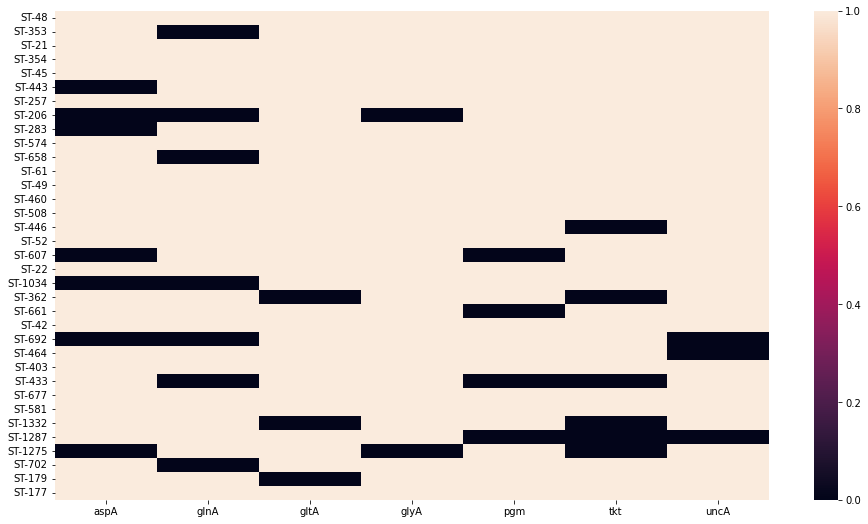

In [151]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap((all_cc == mlst).T, yticklabels=1, ax=ax)

,ST-48,ST-353,ST-21,ST-354,ST-45,ST-443,ST-257,ST-206,ST-283,ST-574,...,ST-403,ST-433,ST-677,ST-581,ST-1332,ST-1287,ST-1275,ST-702,ST-179,ST-177
aspA,2,7,2,8,4,24,9,2,2,7,...,10,2,10,7,2,84,27,2,1,17
glnA,4,17,1,10,7,17,2,21,7,53,...,27,59,81,15,1,106,33,52,6,2
gltA,1,5,1,2,10,2,4,5,40,2,...,16,4,50,5,29,29,22,29,7,8
glyA,2,2,3,2,4,15,62,37,4,10,...,19,38,99,62,28,28,49,48,2,5
pgm,7,10,2,11,1,23,4,2,42,11,...,10,17,120,67,58,74,43,127,40,8
tkt,1,3,1,12,7,3,5,1,51,3,...,5,12,76,3,25,136,82,99,32,2
uncA,5,6,5,6,1,12,6,5,1,3,...,7,35,52,6,58,90,31,23,3,4


In [138]:
all_cc.columns

Index(['ST-48', 'ST-353', 'ST-21', 'ST-354', 'ST-45', 'ST-443', 'ST-257',
       'ST-206', 'ST-283', 'ST-574', 'ST-658', 'ST-61', 'ST-49', 'ST-460',
       'ST-508', 'ST-446', 'ST-52', 'ST-607', 'ST-22', 'ST-1034', 'ST-362',
       'ST-661', 'ST-42', 'ST-692', 'ST-464', 'ST-403', 'ST-433', 'ST-677',
       'ST-581', 'ST-1332', 'ST-1287', 'ST-1275', 'ST-702', 'ST-179',
       'ST-177'],
      dtype='object')

['ST-21',
 'ST-22',
 'ST-41',
 'ST-42',
 'ST-45',
 'ST-48',
 'ST-49',
 'ST-52',
 'ST-61',
 'ST-177',
 'ST-179',
 'ST-206',
 'ST-257',
 'ST-283',
 'ST-353',
 'ST-354',
 'ST-362',
 'ST-403',
 'ST-433',
 'ST-443',
 'ST-446',
 'ST-460',
 'ST-464',
 'ST-508',
 'ST-573',
 'ST-574',
 'ST-581',
 'ST-607',
 'ST-658',
 'ST-661',
 'ST-677',
 'ST-682',
 'ST-692',
 'ST-702',
 'ST-828',
 'ST-952',
 'ST-1034',
 'ST-1150',
 'ST-1264',
 'ST-1275',
 'ST-1287',
 'ST-1304',
 'ST-1325',
 'ST-1332',
 'ST-1347']